<a href="https://colab.research.google.com/github/Hwajun1323/ML/blob/master/1model_arch/convLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install keras-metrics

In [ ]:
pip install scikit-plot

In [ ]:
!apt install graphviz
!pip install pydot pydot-ng
!echo "Double check with Python 3"
!python -c "import pydot"

Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.40.1-2).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
Double check with Python 3


In [2]:
import keras
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from tensorflow.keras.utils import plot_model

import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score , cross_validate
import keras_metrics as km

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import graphviz
import pydot_ng as pydot
from keras.optimizers import SGD  # Stochastic Gradient Decent
from keras.utils import np_utils


In [3]:
#data_dir = "/content/drive/My Drive/dataset/video_data"
data_dir = "/content/drive/My Drive/Data/video_data"

#data_dir = "video_data/"
img_height, img_width = 64, 64
seq_len = 20

classes = ["DiningRoom","Office", "Restaurant", "Museum", "ChildsRoom"]
num_classes = len(classes)
print("Number of Class: ", num_classes)

#  Creating frames from videos

def frames_extraction(video_path):
    frames_list = []

    vidObj = cv2.VideoCapture(video_path)
    total_frames =int(vidObj.get(cv2.CAP_PROP_FRAME_COUNT)) 
    frames_step = total_frames/seq_len

    count = 0

    while count < seq_len:
        for i in range(seq_len):
            vidObj.set(1,i*frames_step)
            success, image = vidObj.read()
            if success:
                try:
                    image = cv2.resize(image, (img_height, img_width))
                except:
                    break
                frames_list.append(image)
                count += 1
            else:
                print("Defected frame")
                break

    return frames_list

# Create the actual data from the sequence of images

def create_data(input_dir):
    X = []
    Y = []

    classes_list = os.listdir(input_dir)

    for c in classes_list:
        print(c)
        files_list = os.listdir(os.path.join(input_dir, c))
        print(c, ': ' , len(files_list))
        print(c ,' index number : ', classes.index(c) )
        for f in files_list:
            frames = frames_extraction(os.path.join(os.path.join(input_dir, c), f))
            if len(frames) == seq_len:
                X.append(frames)

                y = [0] * len(classes)
                y[classes.index(c)] = 1
                Y.append(y)

    X = np.asarray(X)
    Y = np.asarray(Y)
    
    return X, Y

Number of Class:  5


In [4]:
X, Y = create_data(data_dir)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, shuffle=True, random_state=0)

Office
Office :  178
Office  index number :  1
Restaurant
Restaurant :  178
Restaurant  index number :  2
DiningRoom
DiningRoom :  178
DiningRoom  index number :  0
Museum
Museum :  178
Museum  index number :  3
ChildsRoom
ChildsRoom :  178
ChildsRoom  index number :  4


In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(X.shape)

(712, 20, 64, 64, 3)
(178, 20, 64, 64, 3)
(712, 5)
(178, 5)
(890, 20, 64, 64, 3)


In [5]:
model = Sequential()

model.add(ConvLSTM2D(filters=64, kernel_size=(3, 3), return_sequences=False, data_format="channels_last", input_shape=(seq_len, img_height, img_width, 3)))
model.add(Dropout(0.5))
#model.add(ConvLSTM2D(filters=32, kernel_size=(3, 3), return_sequences=False, data_format="channels_last"))
#model.add(Dropout(0.5))

#model.add(BatchNormalization())
#model.add(MaxPooling2D(pool_size = (2, 2)))
#model.add(GlobalAveragePooling2D())

model.add(Flatten())
model.add(Dense(256, activation="relu"))
#model.add(Dropout(0.5))
#model.add(Dense(128, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation = "softmax"))

model.summary()

opt = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=["accuracy"])

#history = model.fit(x=X_train, y=y_train, epochs=90, batch_size=40, shuffle=True, validation_split=0.2)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d (ConvLSTM2D)    (None, 62, 62, 64)        154624    
_________________________________________________________________
dropout (Dropout)            (None, 62, 62, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 246016)            0         
_________________________________________________________________
dense (Dense)                (None, 256)               62980352  
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 1285      
Total params: 63,136,261
Trainable params: 63,136,261
Non-trainable params: 0
____________________________________________

In [ ]:
history = model.fit(x=X_train, y=y_train, epochs=80, batch_size=40, shuffle=True, validation_split=0.2)

# Result
loss, acc = model.evaluate(X_test, y_test)
print("\nLoss: {}, Acc: {}".format(loss,acc))

Epoch 1/80
15/15 [==============================] - 53s 767ms/step - loss: 1.6882 - accuracy: 0.2498 - val_loss: 1.6022 - val_accuracy: 0.2378
Epoch 2/80
15/15 [==============================] - 10s 678ms/step - loss: 1.6122 - accuracy: 0.2968 - val_loss: 1.6060 - val_accuracy: 0.1748
Epoch 3/80
15/15 [==============================] - 10s 678ms/step - loss: 1.6232 - accuracy: 0.2250 - val_loss: 1.5960 - val_accuracy: 0.1678
Epoch 4/80
15/15 [==============================] - 10s 678ms/step - loss: 1.5673 - accuracy: 0.3108 - val_loss: 1.5953 - val_accuracy: 0.1678
Epoch 5/80
15/15 [==============================] - 10s 677ms/step - loss: 1.5208 - accuracy: 0.3153 - val_loss: 1.5918 - val_accuracy: 0.1538
Epoch 6/80
15/15 [==============================] - 10s 678ms/step - loss: 1.4985 - accuracy: 0.3521 - val_loss: 1.5599 - val_accuracy: 0.3077
Epoch 7/80
15/15 [==============================] - 10s 678ms/step - loss: 1.4922 - accuracy: 0.3584 - val_loss: 1.5559 - val_accuracy: 0.3007

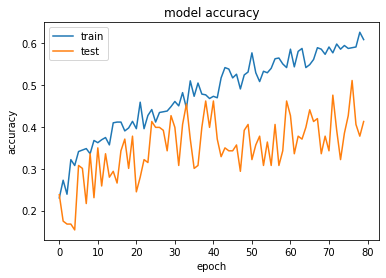

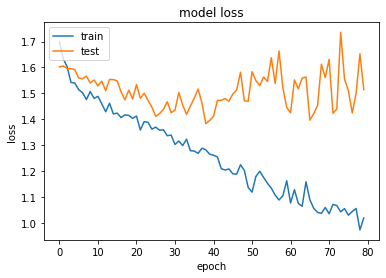

In [ ]:
# Visualize the plot

## summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
## summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
predictions = model.predict(X_test)
print('prediction result: ',np.argmax(predictions[0]))
print('actual result: ', y_test[0])

# Evaluation of model
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)
targets = ['DiningRoom','Office', 'Restaurant', 'Museum', 'ChildsRoom']

print('Classification Report:\n')
print(classification_report(y_true, y_pred, target_names=targets))

prediction result:  2
actual result:  [1 0 0 0 0]
Classification Report:

              precision    recall  f1-score   support

  DiningRoom       0.41      0.45      0.43        38
      Office       0.69      0.39      0.50        28
  Restaurant       0.55      0.80      0.65        40
      Museum       0.52      0.28      0.36        40
  ChildsRoom       0.43      0.56      0.49        32

    accuracy                           0.50       178
   macro avg       0.52      0.50      0.49       178
weighted avg       0.52      0.50      0.49       178



confusion matrix:
  [[17  1  5  1 14]
 [ 6 11  0  6  5]
 [ 3  1 32  3  1]
 [ 9  1 15 11  4]
 [ 6  2  6  0 18]]


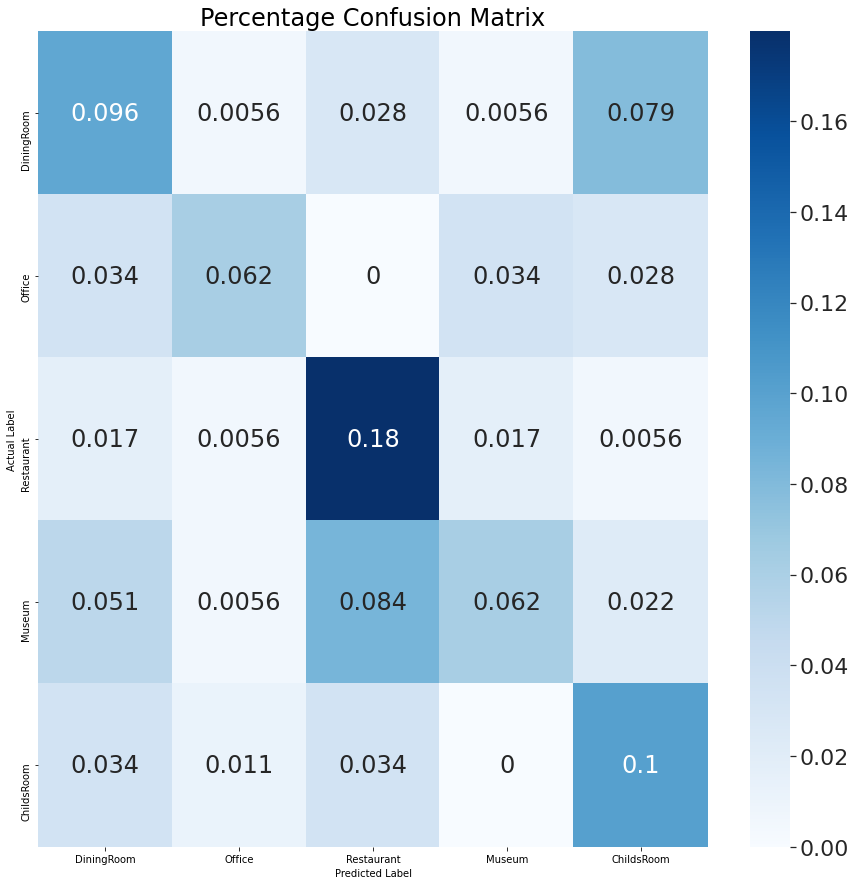

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred) 
print('confusion matrix:\n ', cm)

row1 = cm[0,:] / 178
row2 = cm[1,:] / 178
row3 = cm[2,:] / 178
row4 = cm[3,:] / 178
row5 = cm[4,:] / 178

norm_cm = np.vstack((row1, row2))
norm_cm = np.vstack((norm_cm, row3))
norm_cm = np.vstack((norm_cm, row4))
norm_cm = np.vstack((norm_cm, row5))

import seaborn as sns
fig, ax = plt.subplots(figsize=(15,15))
x_axis_labels = ['DiningRoom','Office', 'Restaurant', 'Museum', 'ChildsRoom']
y_axis_labels = ['DiningRoom','Office', 'Restaurant', 'Museum', 'ChildsRoom'] 
sns.set(font_scale=2.0)
f = sns.heatmap(norm_cm, cmap="Blues", xticklabels=x_axis_labels, yticklabels=y_axis_labels, annot=True)
plt.title("Confusion Matrix")
plt.title("Percentage Confusion Matrix")
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()


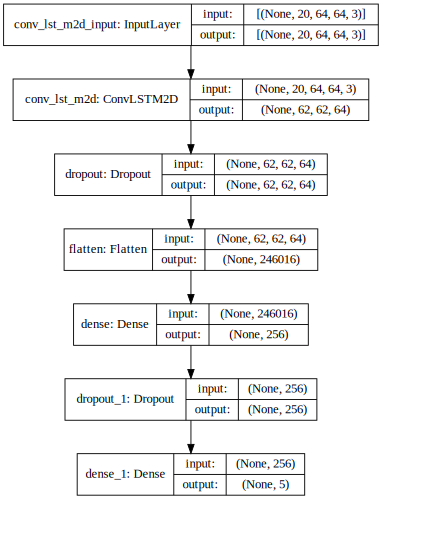

In [6]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes=True, dpi=65).create(prog='dot', format='svg'))

In [7]:
plot_model(model, to_file = 'model_structure_plot.png', show_shapes = True, show_layer_names = True)

AssertionError: ignored